# IRGAN

Codigo:

https://github.com/geek-ai/irgan

paper: 

https://arxiv.org/pdf/1705.10513.pdf

Una GAN discreta (como SeqGan) pero que el generador es modelado como un politica de aprendizaje reforzado para seleccionar el documento candidato $d$ en el estado dado la query $q_n$, y una metrica de relevancia $r$ que es entrenado via una politica de gradientes

Quieren poner enfoque en el entrenamiento adversario, osea usan modelos simples e iguales para D y G

El módulo pickle implementa un algoritmo para convertir un objeto Python arbitrario en una serie de bytes. Este proceso también se llama serializar "el objeto". El flujo de bytes que representa el objeto se puede transmitir o almacenar y luego reconstruir para crear un nuevo objeto con las mismas características.

El módulo cPickle implementa el mismo algoritmo, en C en lugar de Python. Es muchas veces más rápido que la implementación de Python, pero no permite al usuario crear una subclase de Pickle. Si la subclasificación no es importante para su uso, probablemente desee utilizar cPickle.

In [1]:
import _pickle as cPickle #guarda el modelo..
from IPython.display import Latex
import tensorflow as tf
import numpy as np
import multiprocessing
import pandas as pd 
import random
cores = multiprocessing.cpu_count()
random.seed(0)
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
import heapq

## Discriminativo DNS

In [2]:
class DIS():
    def __init__(self, itemNum, userNum, emb_dim, lamda, param=None, initdelta=0.05, learning_rate=0.05):
        self.itemNum = itemNum
        self.userNum = userNum
        self.emb_dim = emb_dim
        self.lamda = lamda  # regularization parameters
        self.param = param
        self.initdelta = initdelta
        self.learning_rate = learning_rate
        self.d_params = []

        with tf.compat.v1.compat.v1.variable_scope('discriminator'):
            if self.param is None: #Si no hay param -> inicializacion aleatoria
                self.user_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.userNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.itemNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_bias = tf.compat.v1.Variable(tf.compat.v1.zeros([self.itemNum]))
            else: #lee los parametros del archivo
                self.user_embeddings = tf.compat.v1.Variable(self.param[0])
                self.item_embeddings = tf.compat.v1.Variable(self.param[1])
                self.item_bias = tf.compat.v1.Variable(self.param[2])

        self.d_params = [self.user_embeddings, self.item_embeddings, self.item_bias]

        # placeholder definition
        self.u = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.pos = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.neg = tf.compat.v1.placeholder(tf.compat.v1.int32)

        self.u_embedding = tf.compat.v1.nn.embedding_lookup(self.user_embeddings, self.u)
        self.pos_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.pos)
        self.pos_bias = tf.compat.v1.gather(self.item_bias, self.pos)
        self.neg_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.neg)
        self.neg_bias = tf.compat.v1.gather(self.item_bias, self.neg)

        self.pre_logits = tf.compat.v1.sigmoid(
            tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.pos_embedding - self.neg_embedding),
                          1) + self.pos_bias - self.neg_bias) #
        
        self.reg=  + self.lamda * (
            tf.compat.v1.nn.l2_loss(self.u_embedding) +
            tf.compat.v1.nn.l2_loss(self.pos_embedding) +
            tf.compat.v1.nn.l2_loss(self.pos_bias) +
            tf.compat.v1.nn.l2_loss(self.neg_embedding) +
            tf.compat.v1.nn.l2_loss(self.neg_bias)
        )

        self.pre_loss = -tf.compat.v1.reduce_mean(tf.compat.v1.log(self.pre_logits)) +self.reg
        d_opt = tf.compat.v1.train.GradientDescentOptimizer(self.learning_rate)
        self.d_updates = d_opt.minimize(self.pre_loss, var_list=self.d_params)

        # for test stage, self.u: [batch_size]
        self.all_rating = tf.compat.v1.matmul(self.u_embedding, self.item_embeddings, transpose_a=False,
                                    transpose_b=True) + self.item_bias

        self.all_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias
        # for dns sample
        self.dns_rating = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias

    def save_model(self, sess, filename):
        param = sess.run(self.d_params)
        cPickle.dump(param, open(filename, 'wb'))  #antes w

## utils.py

In [3]:
import linecache
import numpy as np


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# Get batch data from training set
def get_batch_data(file, index, size):  # 1,5->1,2,3,4,5
    user = []
    item = []
    label = []
    for i in range(index, index + size):
        line = linecache.getline(file, i)
        line = line.strip()
        line = line.split()
        user.append(int(line[0]))
        user.append(int(line[0]))
        item.append(int(line[1]))
        item.append(int(line[2]))
        label.append(1.)
        label.append(0.)
    return user, item, label




## Generador

In [13]:
class GEN():
    def __init__(self, itemNum, userNum, emb_dim, lamda, param=None, initdelta=0.05, learning_rate=0.05):
        self.itemNum = itemNum
        self.userNum = userNum
        self.emb_dim = emb_dim
        self.lamda = lamda  # regularization parameters
        self.param = param
        self.initdelta = initdelta
        self.learning_rate = learning_rate
        self.g_params = []

        with tf.compat.v1.variable_scope('generator'):
            if self.param == None: #inicialización de representaciones
                self.user_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.userNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.itemNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_bias = tf.compat.v1.Variable(tf.compat.v1.zeros([self.itemNum]))
            else:
                self.user_embeddings = tf.compat.v1.Variable(self.param[0])
                self.item_embeddings = tf.compat.v1.Variable(self.param[1])
                self.item_bias = tf.compat.v1.Variable(param[2])

            self.g_params = [self.user_embeddings, self.item_embeddings, self.item_bias]

        self.u = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.i = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.reward = tf.compat.v1.placeholder(tf.compat.v1.float32)

        self.u_embedding = tf.compat.v1.nn.embedding_lookup(self.user_embeddings, self.u)
        self.i_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.i)
        self.i_bias = tf.compat.v1.gather(self.item_bias, self.i)

        self.all_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias
        self.i_prob = tf.compat.v1.gather(
            tf.compat.v1.reshape(tf.compat.v1.nn.softmax(tf.compat.v1.reshape(self.all_logits, [1, -1])), [-1]),
            self.i)

        self.gan_loss = -tf.compat.v1.reduce_mean(tf.compat.v1.log(self.i_prob) * self.reward) + self.lamda * (
            tf.compat.v1.nn.l2_loss(self.u_embedding) + tf.compat.v1.nn.l2_loss(self.i_embedding) + tf.compat.v1.nn.l2_loss(self.i_bias))

        g_opt = tf.compat.v1.train.GradientDescentOptimizer(self.learning_rate)
        self.gan_updates = g_opt.minimize(self.gan_loss, var_list=self.g_params)

        # for test stage, self.u: [batch_size]
        self.all_rating = tf.compat.v1.matmul(self.u_embedding, self.item_embeddings, transpose_a=False,
                                    transpose_b=True) + self.item_bias

    def save_model(self, sess, filename):
        param = sess.run(self.g_params)
        cPickle.dump(param, open(filename, 'wb')) #mismo cambio

## Discriminador

$f_{\phi} (q,d)= s_{\phi} (q,d)= s(u,i)= b_i + v_u^Tv_i$

Máquina de factorización sencilla

Su labor es distinguir (clasificar) si el documento $d$ es relevante (real, etiqueta=1, ejemplo positivo) para la consulta $q$. Estimando la probabilidad:

$D(d|q)= \sigma (f_{\phi} (q,d))= \dfrac{exp(f_{\phi} (q,d))}{1+ exp(f_{\phi} (q,d))} $

Su objetivo entonces es maximiza la log verosimititud de distrinción entre documentos verdaderos y generados:

$\phi^{*}=\arg \max _{\phi} \sum_{n=1}^{N}\left(\mathbb{E}_{d \sim p_{\text {true }}\left(d \mid q_{n}, r\right)}\left[\log \left(\sigma\left(f_{\phi}\left(d, q_{n}\right)\right)\right]+\right.\right.$
$\left.\mathbb{E}_{d \sim p_{\theta^{*}}\left(d \mid q_{n}, r\right)}\left[\log \left(1-\sigma\left(f_{\phi}\left(d, q_{n}\right)\right)\right)\right]\right)$

Modelo generativo actual fijo

In [14]:
class DIS():
    def __init__(self, itemNum, userNum, emb_dim, lamda, param=None, initdelta=0.05, learning_rate=0.05):
        self.itemNum = itemNum
        self.userNum = userNum
        self.emb_dim = emb_dim
        self.lamda = lamda  # regularization parameters
        self.param = param
        self.initdelta = initdelta
        self.learning_rate = learning_rate
        self.d_params = []

        with tf.compat.v1.variable_scope('discriminator'):
          #inicializacion
            if self.param == None:
                self.user_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.userNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.itemNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_bias = tf.compat.v1.Variable(tf.compat.v1.zeros([self.itemNum]))
            else:
                self.user_embeddings = tf.compat.v1.Variable(self.param[0])
                self.item_embeddings = tf.compat.v1.Variable(self.param[1])
                self.item_bias = tf.compat.v1.Variable(self.param[2])

        self.d_params = [self.user_embeddings, self.item_embeddings, self.item_bias]

        # placeholder definition
        self.u = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.i = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.label = tf.compat.v1.placeholder(tf.compat.v1.float32)
        #indexaciones
        #V_u
        self.u_embedding = tf.compat.v1.nn.embedding_lookup(self.user_embeddings, self.u)
        #V_i
        self.i_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.i)
        #b_i
        self.i_bias = tf.compat.v1.gather(self.item_bias, self.i)
        #b_i+vu*v_i
        self.pre_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.i_embedding), 1) + self.i_bias
        #sigmoide cross entropy con regularización l2 
        self.pre_loss = tf.compat.v1.nn.sigmoid_cross_entropy_with_logits(labels=self.label,
                                                                logits=self.pre_logits) + self.lamda * (
            tf.compat.v1.nn.l2_loss(self.u_embedding) + tf.compat.v1.nn.l2_loss(self.i_embedding) + tf.compat.v1.nn.l2_loss(self.i_bias))
        #SGD
        d_opt = tf.compat.v1.train.GradientDescentOptimizer(self.learning_rate)
        self.d_updates = d_opt.minimize(self.pre_loss, var_list=self.d_params)
        #Recompensa: 
        #b_i+vu*v_i
        self.reward_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.i_embedding),
                                           1) + self.i_bias
        #2sig(f)-1
        self.reward = 2 * (tf.compat.v1.sigmoid(self.reward_logits) - 0.5)

        # for test stage, self.u: [batch_size]
        self.all_rating = tf.compat.v1.matmul(self.u_embedding, self.item_embeddings, transpose_a=False,
                                    transpose_b=True) + self.item_bias

        self.all_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias
        
        self.NLL = -tf.compat.v1.reduce_mean(tf.compat.v1.log(
            tf.compat.v1.gather(tf.compat.v1.reshape(tf.compat.v1.nn.softmax(tf.compat.v1.reshape(self.all_logits, [1, -1])), [-1]), self.i))
        )
        # for dns sample
        self.dns_rating = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias

    def save_model(self, sess, filename):
        param = sess.run(self.d_params)
        cPickle.dump(param, open(filename, 'w'))

# Adaptación de IRGAN, solo feedback

## Lectura Amazon 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

#workdir = '/content/drive/MyDrive/dataset_ml/amazon_men_actualizado/' 
workdir = '/content/drive/MyDrive/dataset_ml/women/' 

usuarios_train = np.load(workdir+'dic_train_women.npy',allow_pickle='TRUE')
usuarios_train=list(usuarios_train.reshape(-1,1))[0][0]
usuarios_test = np.load(workdir+'dic_test_women.npy',allow_pickle='TRUE')
usuarios_test=list(usuarios_test.reshape(-1,1))[0][0]

DIS_TRAIN_FILE = "dis-train.txt"
DIS_MODEL_FILE =   "model_dns.pkl" #rutaaaa

Mounted at /content/drive


In [5]:
#########################################################################################
# Hyper-parameters
#########################################################################################
EMB_DIM = 10
DNS_K=5

In [6]:
user_pos_test = {}
user_pos_train= {}
c_t=0
all_items= []


for u in usuarios_train.keys():
  for item in usuarios_train[u]:
    if item[b"productid"] not in all_items:
      all_items.append(item[b"productid"])
    
    if u not in user_pos_train: #nuevo
      user_pos_train[u] = [item[b"productid"]]
    else: #sino agrego
      user_pos_train[u].append(item[b"productid"])
all_user= list(user_pos_train.keys())

for u in usuarios_train.keys():    
  item=usuarios_test[u][0]
  if item[b"productid"] not in all_items:
    c_t+=1
  else:
    user_pos_test[u] = [item[b"productid"]]

ITEM_NUM=len(all_items)
USER_NUM= len(usuarios_train.keys())

In [7]:
print("% de items en test que no estan en train: ",c_t/len(all_items)*100)
print("n item: ", ITEM_NUM, "n usuarios: ", USER_NUM)

% de items en test que no estan en train:  2.7743271221532093
n item:  7245 n usuarios:  3158


## inicializacion

In [8]:
def generate_dns(sess, model, filename): #dy
    """"
    crea tripletas u,i,j con los id originales
    """
    data = []
    for u in user_pos_train.keys(): #para cada usuario
        pos = user_pos_train[u] #lo que consumio
        all_rating = sess.run(model.dns_rating, {model.u: all_user.index(u) }) #evalua el modelo
        all_rating = np.array(all_rating)
        neg = []
        candidates = list(set(all_items) - set(pos) )#los que no ha consumido

        for _ in range(len(pos)): #para cada item
            choice = np.random.choice(candidates, DNS_K) #se escogen DN_K aleatoriamente de los candidatos
            choice= [list(all_items).index(i) for i in choice]
            choice_score = all_rating[choice] # sus rating
            neg.append(choice[np.argmax(choice_score)] ) #se escoge el items mas cercanos al gusto de esta muestra aleatoria 
        for i in range(len(pos)): #para cada item
            data.append( str(all_user.index(u)) + '\t' + str(list(all_items).index(pos[i]) ) + '\t' + str(neg[i]) )

    with open(filename, 'w')as fout:
        fout.write('\n'.join(data))



def AUC(rating, test_users,dict_tov):
  """
  para cada usuario cuenta cuantos items de una muestra aleatoria tiene rating menor a 
  al rating del item consumido en test
  """
  ans=0
  cc=0
  for user in test_users:
      user_ind= test_users.index(user)
      user_= all_user[user]
      if dict_tov[user_][0] in all_items:
          item_test= list(all_items).index(dict_tov[user_][0])
          cc+=1
          items_train= [ list(all_items).index(i) for i in user_pos_train[user_]]  
          no_considerar= set(items_train+ [item_test]) 
          count=0
          tmpans=0 
          for j in random.sample(range(ITEM_NUM),int(50*(len(no_considerar)-1))): #sample
              if j in no_considerar: continue
              if rating[user_ind,item_test]>rating[user_ind,j]: tmpans+=1
              count+=1

          tmpans/=float(count)
          ans+=tmpans
  
  ans/=float(cc)
  return ans



def simple_test(sess, model, dict_tov): 
  #Calcula AUC para todos los usuarios comparada con el elemento que quedo en el test set
  #dict_tov: test o validacion
 test_users=[ all_user.index(i) for i in dict_tov.keys()]
 user_batch_rating = sess.run(model.all_rating, {model.u: test_users}) 
 batch_result= AUC(user_batch_rating,test_users, dict_tov)
    
 return batch_result

In [9]:
param = None
discriminator = DIS(ITEM_NUM, USER_NUM, EMB_DIM, lamda=0.001, param=param, initdelta=0.1, learning_rate=0.1) #se llama al discriminador DNS


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.run(tf.compat.v1.global_variables_initializer())

generate_dns(sess, discriminator, DIS_TRAIN_FILE)



In [10]:
dis_log = open('dis_log_dns.txt', 'w')
best_AUC=simple_test(sess, discriminator, user_pos_train)
#print(sess.run(discriminator.pre_loss,feed_dict={discriminator.u: [0], discriminator.pos: [1],discriminator.neg: [2]}))
#print("auc discriminador inicializado random", best_AUC)
losses=[]
aucs=[]
for epoch in range(3): #80 antes
  loss_d_=0
  c=0
  generate_dns(sess, discriminator, DIS_TRAIN_FILE)  # dynamic negative sample tarda 20 seg
  with open(DIS_TRAIN_FILE)as fin:
          for line in fin:
              line = line.split()
              c+=1
              u = int(line[0])
              i = int(line[1])
              j = int(line[2])
              #se actualiza el discriminador para la nueva tripleta
              _ ,loss= sess.run([discriminator.d_updates, discriminator.pre_loss ],
                             feed_dict={discriminator.u: [u], discriminator.pos: [i],
                                        discriminator.neg: [j]})
            
            
              #print(line)
              #print(loss, "  :loss")
              #print(sess.run([discriminator.reg, discriminator.pre_logits , discriminator.pre_loss],feed_dict={discriminator.u: [u], discriminator.pos: [i],discriminator.neg: [j]}), "  :reg , prelogits")
              loss_d_+=loss
                
  losses.append(loss_d_/c)
  AUC_actual = simple_test(sess, discriminator,user_pos_train) #evalua
  print ("epoch ", epoch, "dis: ", AUC_actual, "loss: ",loss_d_/c )
  aucs.append(AUC_actual)
    
  if AUC_actual> best_AUC:
          print("mejore")
          best_AUC = AUC_actual
          discriminator.save_model(sess, DIS_MODEL_FILE)
  
  print ("best AUC: ", best_AUC)

  buf = '\t'.join([str(AUC_actual)])
  dis_log.write(str(epoch) + '\t' + buf + '\n')
  dis_log.flush()

dis_log.close()

epoch  0 dis:  0.689622876481914 loss:  0.6833178877187195
mejore
best AUC:  0.689622876481914
epoch  1 dis:  0.6815089680481119 loss:  0.6990605217126498
best AUC:  0.689622876481914
epoch  2 dis:  0.6826374389068182 loss:  0.6968899228210491
best AUC:  0.689622876481914


In [16]:
losses

[0.6833178877187195, 0.6990605217126498, 0.6968899228210491]

In [17]:
aucs

[0.689622876481914, 0.6815089680481119, 0.6826374389068182]

In [18]:
print(simple_test(sess, discriminator,user_pos_train))


0.6819119565067944


In [15]:
print(simple_test(sess, discriminator,user_pos_test))

0.8118560389387383


## minmax

In [19]:
BATCH_SIZE = 1000 #16
import pickle
print ("load model...")


with open( "model_dns.pkl", 'rb') as f: 
  param = pickle.load(f,encoding="bytes")

generator = GEN(ITEM_NUM, USER_NUM, EMB_DIM, lamda=0, param=param, initdelta=0.1,
                    learning_rate=0.01)

discriminator = DIS(ITEM_NUM, USER_NUM, EMB_DIM, lamda=0, param=None, initdelta=0.1,
                        learning_rate=0.01) #segundo discriminador (el que no es DNS)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.run(tf.compat.v1.global_variables_initializer())
g1= simple_test(sess, generator,user_pos_train)
d1=simple_test(sess, discriminator,user_pos_train)
print ("gen ", g1)
print ("dis ", d1)

load model...
gen  0.6887619681507731
dis  0.4967669552478884


In [20]:
#esto es mucho más rapido
def generate_for_d(sess, model, filename):
    data = []
    for u in user_pos_train: #para cada usario
        pos = user_pos_train[u] #sus items 
        rating = sess.run(model.all_rating, {model.u: [all_user.index(u)]}) #completar la matriz 
        rating = np.array(rating[0]) / 0.2  # Temperature #infla los rating #plotear que pasa con la sigmoide cuando ponemos temperatura
        exp_rating = np.exp(rating) 
        prob = exp_rating / np.sum(exp_rating)

        neg = np.random.choice(list(all_items), size=len(pos), p=prob) #muestreo negativo 
        for i in range(len(pos)):
            data.append( str(all_user.index(u)) + '\t' + str(list(all_items).index(pos[i]) ) + '\t' + str(list(all_items).index(neg[i])) ) 

    with open(filename, 'w')as fout:
        fout.write('\n'.join(data))


### normal

In [21]:
# minimax training
dis_log = open('dis_log.txt', 'w')
gen_log = open('gen_log.txt', 'w')
loss_d=[]
auc_epocs_g=[]
auc_epocs_d=[]
loss_g=[]
for epoch in range(15):#15
    print("inicia minmax")
    if epoch >= 0:
        #entrena D 
        for d_epoch in range(10):##100 #para el generador fijo, entrena al discriminador
           # print("empieza a entrenarse el discriminador")
            loss_d_=0
            if d_epoch % 5 == 0:
                generate_for_d(sess, generator, DIS_TRAIN_FILE) #crea un archivo con las tripletas
                #print("pase")
                train_size = file_len(DIS_TRAIN_FILE)
            index = 1
            c=0
            while index < train_size-BATCH_SIZE: #hacer minibatch con etiquetado si es ejemplo positivo o negativo
                if index + BATCH_SIZE <= train_size + 1:
                    input_user, input_item, input_label = get_batch_data(DIS_TRAIN_FILE, index, BATCH_SIZE)
                else:
                    input_user, input_item, input_label = get_batch_data(DIS_TRAIN_FILE, index,
                                                                            train_size - index + 1)
                index += BATCH_SIZE
               # print(index)
                _, loss_dis = sess.run([discriminator.d_updates, discriminator.pre_loss],
                                 feed_dict={discriminator.u: input_user, discriminator.i: input_item, discriminator.label: input_label}) #actualizaciones de los embeddings y bias tales que clasifiquen bien
                loss_d_+=loss_dis
                c+=1
            
            loss_d.append(loss_d_/c)
        
            auc_actual = simple_test(sess, discriminator, user_pos_train)
            auc_epocs_d.append(auc_actual)
            #print ("epoch ", epoch, "dis: ", auc_actual)
            if auc_actual > best_AUC:
                print ('mejore: ', auc_actual)
                best_AUC = auc_actual

        for g_epoch in range(5):  # 50 #para el discriminador fijo (con pesos actualizados), se entrena el generador
            #print("empieza a entrenarse el generador")
            c=0
            loss_g_=0
            for u in user_pos_train: #por cada usuario
                sample_lambda = 0.2 #temperatura
                pos = [list(all_items).index(i) for i in user_pos_train[u]] #peliculas relevantes
                rating = sess.run(generator.all_logits, {generator.u: all_user.index(u)}) #calcula los ratings para ese usuario
                exp_rating = np.exp(rating)
                prob = exp_rating / np.sum(exp_rating)  # prob is generator distribution p_\theta
                pn = (1 - sample_lambda) * prob
                pn[pos] += sample_lambda * 1.0 / len(pos) #pedirle las prob a lo consumido + 0.2/la cantidad de items consumidos
                # Now, pn is the Pn in importance sampling, prob is generator distribution p_\theta
                sample = np.random.choice(np.arange(ITEM_NUM), 2 * len(pos), p=pn) #elige el doble de items c/r a lo consumido
                
                #               # Get reward and adapt it with importance sampling                #######
                reward = sess.run(discriminator.reward, {discriminator.u: all_user.index(u), discriminator.i: sample})
                reward = reward * prob[sample] / pn[sample]
                ######             # Update G              ####################
                _, loss_gen = sess.run([generator.gan_updates, generator.gan_loss],{generator.u: all_user.index(u), generator.i: sample, generator.reward: reward}) #actualiza pesos
                c+=1
                loss_g_+=loss_gen
                
            loss_g.append(loss_g_/c)
            auc_actual = simple_test(sess, generator, user_pos_train)
            auc_epocs_g.append(auc_actual)
            print ("epoch ", epoch, "gen: ", auc_actual)
            buf = '\t'.join([str(auc_actual) ])
            gen_log.write(str(epoch) + '\t' + buf + '\n')
            gen_log.flush()
            if auc_actual > best_AUC:
                print ('mejore: ', auc_actual)
                best_AUC = auc_actual
                generator.save_model(sess, "gan_generator.pkl") #se guarda el mejor modelo, la mejor factorización matricial.

gen_log.close()
dis_log.close()


inicia minmax
epoch  0 gen:  0.6891478951538114
epoch  0 gen:  0.6878868078265239
epoch  0 gen:  0.6889911982674457
epoch  0 gen:  0.6899179240009472
mejore:  0.6899179240009472
epoch  0 gen:  0.6896384744796823
inicia minmax
epoch  1 gen:  0.6899462731106235
mejore:  0.6899462731106235
epoch  1 gen:  0.6891971971310454
epoch  1 gen:  0.6890047075048972
epoch  1 gen:  0.688686401872508
epoch  1 gen:  0.6909502961290741
mejore:  0.6909502961290741
inicia minmax
epoch  2 gen:  0.6889723688336212
epoch  2 gen:  0.6907319874747156
epoch  2 gen:  0.6907734952224494
epoch  2 gen:  0.6903871657867678
epoch  2 gen:  0.6901236483322731
inicia minmax
epoch  3 gen:  0.6921993518555134
mejore:  0.6921993518555134
epoch  3 gen:  0.6910768379106966
epoch  3 gen:  0.6906801368738694
epoch  3 gen:  0.6915441653839723
epoch  3 gen:  0.6907551495162801
inicia minmax
epoch  4 gen:  0.6911566150106054
epoch  4 gen:  0.6906706874075687
epoch  4 gen:  0.691293647159099
epoch  4 gen:  0.6917770647944865
epoc

50 min

In [22]:
print(simple_test(sess, discriminator,user_pos_train))

0.8042844037316292


In [23]:
print(simple_test(sess, generator,user_pos_train))

0.6983644032860279


In [24]:
print(simple_test(sess, discriminator,user_pos_test))

0.523480888328633


In [25]:
print(simple_test(sess, generator,user_pos_test))

0.8635932597914164


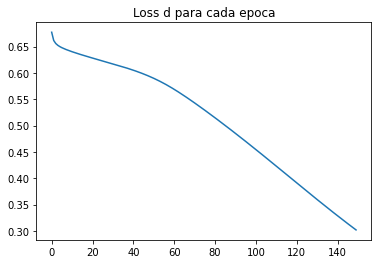

In [26]:
plt.plot(range(len(loss_d)),[np.mean(i) for i in loss_d ])
plt.title("Loss d para cada epoca")
plt.show()

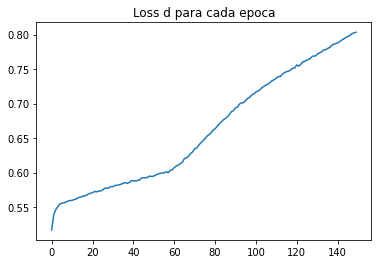

In [27]:
plt.plot(range(len(auc_epocs_d)),[np.mean(i) for i in auc_epocs_d ])
plt.title("Loss d para cada epoca")
plt.show()

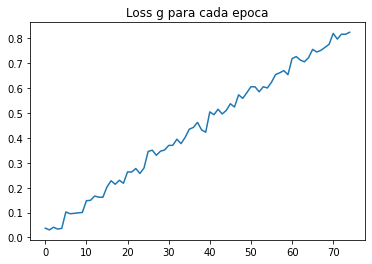

In [28]:
plt.plot(range(len(loss_g)),loss_g)
plt.title("Loss g para cada epoca")
plt.show()

In [1]:
plt.plot(range(len(auc_epocs_g)),auc_epocs_g)
plt.title("auc g para cada epoca")
plt.show()

NameError: ignored

In [ ]:
textfile = open(workdir+"IRGAN_original.txt", "w")
textfile.write(str(loss_d) + "\n")
textfile.write(str(auc_epocs_g) + "\n")
textfile.write(str(auc_epocs_d) + "\n")
textfile.write(str(loss_g) + "\n")
textfile.close()